In [19]:
import pandas as pd
file_path = '/home/abrar/Desktop/Code/Temporal HPC/PM100/pm100_job _w_data_avg_power.csv'

# Read the second sheet (index 1, since indexing starts at 0)
df = pd.read_csv(file_path)

# Now 'df' contains the data from the second sheet

In [1]:
# from tabulate import tabulate

# print(tabulate(df.head(5), headers='keys', tablefmt='psql'))
# # print(tabulate(df_filtered.head(), headers='keys', tablefmt='psql'))

In [ ]:
# df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231125 entries, 0 to 231124
Data columns (total 41 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   cores_alloc_layout      231125 non-null  object 
 1   cores_allocated         231125 non-null  object 
 2   cores_per_task          231125 non-null  int64  
 3   derived_ec              231125 non-null  object 
 4   eligible_time           231125 non-null  object 
 5   end_time                231125 non-null  object 
 6   group_id                231125 non-null  int64  
 7   job_id                  231125 non-null  int64  
 8   job_state               231125 non-null  object 
 9   nodes                   231125 non-null  object 
 10  num_cores_req           231125 non-null  int64  
 11  num_cores_alloc         231125 non-null  int64  
 12  num_nodes_req           231125 non-null  int64  
 13  num_nodes_alloc         231125 non-null  int64  
 14  num_tasks           

In [9]:
# Removing outliers
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

def remove_outliers_iqr(df, columns, threshold=1.5):
    """Removes outliers based on the IQR method."""
    df_out = df.copy()
    for col in columns:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df_out = df_out[(df_out[col] >= lower_bound) & (df_out[col] <= upper_bound)]
    return df_out

def remove_outliers_zscore(df, columns, threshold=3):
    """Removes outliers based on the Z-score method."""
    df_out = df.copy()
    for col in columns:
        z_scores = np.abs((df_out[col] - df_out[col].mean()) / df_out[col].std())
        df_out = df_out[z_scores < threshold]
    return df_out

def remove_outliers_modified_zscore(df, columns, threshold=3.5):
    """Removes outliers based on the modified Z-score method."""
    df_out = df.copy()
    for col in columns:
        med = df_out[col].median()
        mad = np.median(np.abs(df_out[col] - med))
        modified_z_scores = np.abs(0.6745 * (df_out[col] - med) / mad)
        df_out = df_out[modified_z_scores < threshold]
    return df_out

def remove_outliers_dbscan(df, columns, eps=0.5, min_samples=5):
    """Removes outliers based on the DBSCAN algorithm."""
    df_out = df.copy()
    X = df_out[columns]
    
    # Scale the data - important for distance-based methods like DBSCAN
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X_scaled)

    # Identify outliers (data points labeled as -1)
    df_out['outlier'] = clusters
    df_out = df_out[df_out['outlier'] != -1]
    df_out.drop('outlier', axis=1, inplace=True)

    return df_out

def remove_outliers_isolation_forest(df, columns, contamination=0.01):
    """Removes outliers based on the Isolation Forest algorithm."""
    df_out = df.copy()
    X = df_out[columns]

    # Isolation Forest works well with scaled data but can handle unscaled data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    outliers = iso_forest.fit_predict(X_scaled)

    # Identify outliers (data points labeled as -1)
    df_out['outlier'] = outliers
    df_out = df_out[df_out['outlier'] != -1]
    df_out.drop('outlier', axis=1, inplace=True)

    return df_out

In [12]:
# Example usage:
runtime_cols = ['run_time'] # , 'mean_cpu_power', 'mean_mem_power'

# Choose one method:
df_no_run_time_outliers_iqr = remove_outliers_iqr(df, runtime_cols)
# df_no_outliers_zscore = remove_outliers_zscore(df, power_cols)
# df_no_outliers_mod_zscore = remove_outliers_modified_zscore(df, power_cols)
# df_no_outliers_dbscan = remove_outliers_dbscan(df, power_cols, eps=3, min_samples=10) # Tune eps and min_samples
# df_no_outliers_iso_forest = remove_outliers_isolation_forest(df, power_cols, contamination=0.02) # Tune contamination

# Now use df_no_outliers... for GNN training

print(f"Original DataFrame shape: {df.shape}")
print(f"DataFrame shape after outlier removal (IQR): {df_no_run_time_outliers_iqr.shape}")
# print(f"DataFrame shape after outlier removal (Z-score): {df_no_outliers_zscore.shape}")
# print(f"DataFrame shape after outlier removal (Mod Z-score): {df_no_outliers_mod_zscore.shape}")
# print(f"DataFrame shape after outlier removal (DBSCAN): {df_no_outliers_dbscan.shape}")
# print(f"DataFrame shape after outlier removal (Isolation Forest): {df_no_outliers_iso_forest.shape}")

Original DataFrame shape: (231125, 41)
DataFrame shape after outlier removal (IQR): (196567, 41)


In [13]:
# Example usage:
power_cols = ['mean_node_power'] # , 'mean_cpu_power', 'mean_mem_power'

# Choose one method:
df_no_node_power_run_time_outliers_iqr = remove_outliers_iqr(df_no_run_time_outliers_iqr, power_cols)
# df_no_outliers_zscore = remove_outliers_zscore(df, power_cols)
# df_no_outliers_mod_zscore = remove_outliers_modified_zscore(df, power_cols)
# df_no_outliers_dbscan = remove_outliers_dbscan(df, power_cols, eps=3, min_samples=10) # Tune eps and min_samples
# df_no_outliers_iso_forest = remove_outliers_isolation_forest(df, power_cols, contamination=0.02) # Tune contamination

# Now use df_no_outliers... for GNN training

print(f"Original DataFrame shape: {df.shape}")
print(f"DataFrame shape after outlier removal (IQR): {df_no_node_power_run_time_outliers_iqr.shape}")
# print(f"DataFrame shape after outlier removal (Z-score): {df_no_outliers_zscore.shape}")
# print(f"DataFrame shape after outlier removal (Mod Z-score): {df_no_outliers_mod_zscore.shape}")
# print(f"DataFrame shape after outlier removal (DBSCAN): {df_no_outliers_dbscan.shape}")
# print(f"DataFrame shape after outlier removal (Isolation Forest): {df_no_outliers_iso_forest.shape}")

Original DataFrame shape: (231125, 41)
DataFrame shape after outlier removal (IQR): (163308, 41)


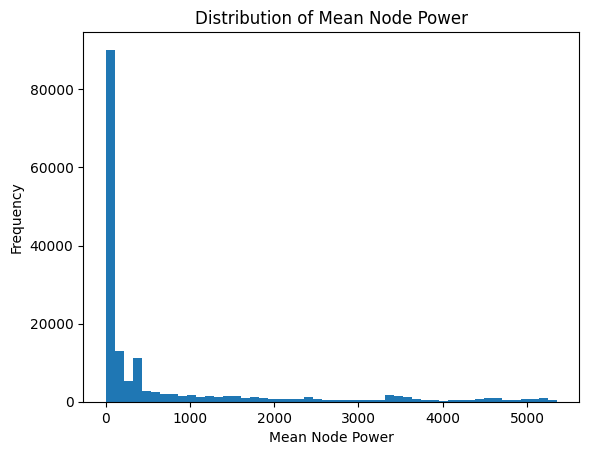

In [17]:
import matplotlib.pyplot as plt

df_no_node_power_run_time_outliers_iqr['run_time'].plot.hist(bins=50)
plt.title('Distribution of Mean Node Power')
plt.xlabel('Mean Node Power')
plt.ylabel('Frequency')
plt.show()

In [16]:
print(df_no_node_power_run_time_outliers_iqr.describe())

       cores_per_task       group_id        job_id  num_cores_req  \
count   163308.000000  163308.000000  1.633080e+05  163308.000000   
mean        15.667334   25215.294211  3.122049e+06      85.796244   
std         17.585923     736.085993  1.801799e+06      88.926227   
min          1.000000     915.000000  1.200000e+01       1.000000   
25%          1.000000   25200.000000  1.561397e+06      16.000000   
50%          8.000000   25200.000000  3.116770e+06      64.000000   
75%         32.000000   25200.000000  4.685758e+06     128.000000   
max        128.000000   53925.000000  6.242697e+06   12800.000000   

       num_cores_alloc  num_nodes_req  num_nodes_alloc      num_tasks  \
count    163308.000000  163308.000000    163308.000000  158404.000000   
mean        105.424107       1.157763         1.158602      11.608943   
std         108.874514       0.744013         0.745080      21.962067   
min           4.000000       1.000000         1.000000       0.000000   
25%          

In [159]:
df = df_no_node_power_run_time_outliers_iqr

In [160]:
# cleaning shared column
df = df[df['shared'] != 'USER']
df['shared'] = df['shared'].replace('OK', '1')
df['shared'] = df['shared'].astype(int)

/tmp/ipykernel_22695/1726974308.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shared'] = df['shared'].replace('OK', '1')
/tmp/ipykernel_22695/1726974308.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shared'] = df['shared'].astype(int)


In [161]:
# cleaning parition column
df = df[df['partition'] != 2]
# df['partition'] = df['shared'].replace('OK', '1')
df['partition'] = df['partition'].astype(int)

In [162]:
# swapping columns: parition and priority
col_swap = {'partition': 'priority', 'priority': 'partition'}
df = df.rename(columns=col_swap)

In [163]:
# # cleaning state reason column
df['state_reason'] = df['state_reason'].fillna('No reason')

In [164]:
print(df['num_tasks'].value_counts())

num_tasks
4.0      92651
32.0     24448
8.0      23626
1.0      14875
16.0      9456
24.0      6002
0.0       2494
3.0       2352
128.0     2328
2.0       2213
64.0      1938
12.0       987
192.0      653
256.0      401
96.0       156
80.0       113
6.0        100
9.0         47
36.0        33
384.0       30
5.0         29
18.0        26
30.0        19
40.0        18
20.0        18
160.0       16
512.0       14
7.0         12
48.0        11
60.0         8
10.0         8
28.0         4
72.0         3
120.0        3
31.0         3
56.0         2
29.0         2
34.0         1
54.0         1
648.0        1
400.0        1
144.0        1
100.0        1
180.0        1
90.0         1
84.0         1
14.0         1
Name: count, dtype: int64


In [165]:
df['num_tasks'].isnull().sum()

np.int64(6206)

In [166]:
# # filtered_df = df[df['state_reason'] == 'TimeLimit']
# filtered_df = df[df['state_reason'].isna()]
# print(filtered_df)

In [167]:
# print(filtered_df['job_state'].value_counts())

In [168]:
df.columns

Index(['cores_alloc_layout', 'cores_allocated', 'cores_per_task', 'derived_ec',
       'eligible_time', 'end_time', 'group_id', 'job_id', 'job_state', 'nodes',
       'num_cores_req', 'num_cores_alloc', 'num_nodes_req', 'num_nodes_alloc',
       'num_tasks', 'priority', 'partition', 'qos', 'req_nodes', 'req_switch',
       'run_time', 'shared', 'start_time', 'state_reason', 'submit_time',
       'threads_per_core', 'time_limit', 'num_gpus_req', 'num_gpus_alloc',
       'mem_req', 'mem_alloc', 'user_id', 'node_power_consumption',
       'mem_power_consumption', 'cpu_power_consumption', 'node_power_list',
       'cpu_power_list', 'mem_power_list', 'mean_node_power', 'mean_cpu_power',
       'mean_mem_power'],
      dtype='object')

In [169]:
# Columns to keep
columns_to_keep = [
    'job_id', 'job_state', 'submit_time', 'eligible_time', 'start_time', 'end_time', 'run_time',
    'cores_per_task', 'shared', 'partition', 'priority','num_tasks', 'state_reason',
    'num_cores_alloc', 'num_nodes_alloc', 'num_gpus_alloc', 'mem_alloc', 
    'mean_node_power', 'mean_cpu_power', 'mean_mem_power'
]

# Subset the dataset
subset_df = df[columns_to_keep]

# # Save the subset dataset as a new file (optional)
# output_path = '/mnt/data/subset_dataset.csv'
# subset_df.to_csv(output_path, index=False)

In [170]:
# Replace NaN values in the specified columns with the mean
columns_to_impute = ['mean_cpu_power', 'mean_mem_power', 'num_tasks']

# Perform mean imputation
if 'subset_df' in locals():  # Check if the DataFrame is loaded
    subset_df[columns_to_impute] = subset_df[columns_to_impute].fillna(subset_df[columns_to_impute].mean())


/tmp/ipykernel_22695/3602614397.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df[columns_to_impute] = subset_df[columns_to_impute].fillna(subset_df[columns_to_impute].mean())


In [171]:
# Convert time columns to datetime
time_columns = ['submit_time', 'eligible_time', 'start_time', 'end_time']
for col in time_columns:
    subset_df[col] = pd.to_datetime(subset_df[col])

/tmp/ipykernel_22695/2911699287.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df[col] = pd.to_datetime(subset_df[col])
/tmp/ipykernel_22695/2911699287.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df[col] = pd.to_datetime(subset_df[col])
/tmp/ipykernel_22695/2911699287.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [172]:
# Sort the DataFrame by the 'submit_time' column
subset_df = subset_df.sort_values('submit_time')

In [173]:
# Sequentially assign job IDs
subset_df['job_id'] = range(1, len(subset_df) + 1)

In [174]:
# subset_df['mean_cpu_power'].isnull().sum()

In [175]:
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191315 entries, 18460 to 218499
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   job_id           191315 non-null  int64              
 1   job_state        191315 non-null  object             
 2   submit_time      191315 non-null  datetime64[ns, UTC]
 3   eligible_time    191315 non-null  datetime64[ns, UTC]
 4   start_time       191315 non-null  datetime64[ns, UTC]
 5   end_time         191315 non-null  datetime64[ns, UTC]
 6   run_time         191315 non-null  int64              
 7   cores_per_task   191315 non-null  int64              
 8   shared           191315 non-null  int64              
 9   partition        191315 non-null  int64              
 10  priority         191315 non-null  int64              
 11  num_tasks        191315 non-null  float64            
 12  state_reason     191315 non-null  object             
 13  

In [176]:
from tabulate import tabulate

print(tabulate(subset_df.head(5), headers='keys', tablefmt='psql'))
# print(tabulate(df_filtered.head(), headers='keys', tablefmt='psql'))

+-------+----------+-------------+---------------------------+---------------------------+---------------------------+---------------------------+------------+------------------+----------+-------------+------------+-------------+----------------+-------------------+-------------------+------------------+-------------+-------------------+------------------+------------------+
|       |   job_id | job_state   | submit_time               | eligible_time             | start_time                | end_time                  |   run_time |   cores_per_task |   shared |   partition |   priority |   num_tasks | state_reason   |   num_cores_alloc |   num_nodes_alloc |   num_gpus_alloc |   mem_alloc |   mean_node_power |   mean_cpu_power |   mean_mem_power |
|-------+----------+-------------+---------------------------+---------------------------+---------------------------+---------------------------+------------+------------------+----------+-------------+------------+-------------+------------

In [177]:
subset_df['wait_time'] = (subset_df['end_time'] - subset_df['start_time']).dt.total_seconds()
# subset_df = subset_df['wait_time'].dt.total_seconds()

In [178]:
subset_df.dropna()

,job_id,job_state,submit_time,eligible_time,start_time,end_time,run_time,cores_per_task,shared,partition,...,num_tasks,state_reason,num_cores_alloc,num_nodes_alloc,num_gpus_alloc,mem_alloc,mean_node_power,mean_cpu_power,mean_mem_power,wait_time
18460,1,TIMEOUT,2020-05-05 15:55:59+00:00,2020-05-05 15:55:59+00:00,2020-05-05 15:56:00+00:00,2020-05-06 15:56:07+00:00,86407,32,1,329756,...,12.852698,TimeLimit,128,1,4,237,1206.606862,222.946608,39.152638,86407.0
18462,2,TIMEOUT,2020-05-05 16:01:00+00:00,2020-05-05 16:01:00+00:00,2020-05-05 16:01:00+00:00,2020-05-06 16:01:07+00:00,86407,32,1,329756,...,12.852698,TimeLimit,128,1,4,237,1240.646884,273.697368,37.987440,86407.0
18461,3,TIMEOUT,2020-05-05 16:21:46+00:00,2020-05-05 16:21:46+00:00,2020-05-05 16:21:47+00:00,2020-05-06 16:22:07+00:00,86420,32,1,329691,...,12.852698,TimeLimit,128,1,4,237,1102.062371,224.689121,37.608346,86420.0
18459,4,TIMEOUT,2020-05-05 20:53:46+00:00,2020-05-05 20:53:46+00:00,2020-05-05 20:53:46+00:00,2020-05-06 19:54:12+00:00,82826,1,1,328318,...,12.852698,TimeLimit,32,4,16,898,2241.573820,304.519221,127.146780,82826.0
8412,5,COMPLETED,2020-05-06 06:41:32+00:00,2020-05-06 06:41:32+00:00,2020-05-06 06:41:51+00:00,2020-05-06 10:22:34+00:00,13243,4,1,327135,...,12.852698,No reason,4,1,4,64,875.916955,73.930783,36.761384,13243.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218482,191311,COMPLETED,2020-10-12 23:32:58+00:00,2020-10-12 23:32:58+00:00,2020-10-12 23:35:00+00:00,2020-10-12 23:35:02+00:00,2,1,1,167166,...,16.000000,No reason,16,4,16,29,2120.000000,228.000000,146.000000,2.0
218507,191312,FAILED,2020-10-12 23:34:45+00:00,2020-10-12 23:34:45+00:00,2020-10-12 23:34:59+00:00,2020-10-12 23:35:14+00:00,15,1,1,194728,...,1.000000,NonZeroExitCode,4,1,1,29,580.000000,94.000000,36.000000,15.0
218497,191313,COMPLETED,2020-10-12 23:43:15+00:00,2020-10-12 23:43:15+00:00,2020-10-12 23:45:13+00:00,2020-10-12 23:45:31+00:00,18,1,1,194451,...,1.000000,No reason,4,1,1,29,570.000000,92.000000,38.000000,18.0
218501,191314,COMPLETED,2020-10-12 23:47:17+00:00,2020-10-12 23:47:17+00:00,2020-10-12 23:49:19+00:00,2020-10-12 23:49:21+00:00,2,1,1,167185,...,16.000000,No reason,16,4,16,29,2130.000000,228.000000,144.000000,2.0


In [179]:
# subset_df['job_id'].duplicated().sum()

In [180]:
subset_df.describe()

,job_id,run_time,cores_per_task,shared,partition,priority,num_tasks,num_cores_alloc,num_nodes_alloc,num_gpus_alloc,mem_alloc,mean_node_power,mean_cpu_power,mean_mem_power,wait_time
count,191315.000000,191315.000000,191315.000000,191315.000000,1.913150e+05,191315.000000,191315.000000,191315.000000,191315.000000,191315.000000,191315.000000,191315.000000,191315.000000,191315.000000,191315.000000
mean,95658.000000,5615.282686,15.597376,0.829517,1.864435e+05,0.992928,12.852698,107.315872,1.173761,4.127314,213.540993,841.263481,142.347877,44.559368,5615.282686
std,55228.027712,16328.279164,17.354117,0.376058,9.496610e+04,0.083798,24.143125,106.953631,0.732607,3.212431,190.284860,369.343803,118.132777,25.982101,16328.279164
min,1.000000,1.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,20.000000,22.666667,28.000000,1.000000
25%,47829.500000,7.000000,1.000000,1.000000,9.286500e+04,1.000000,4.000000,32.000000,1.000000,4.000000,118.000000,560.000000,78.000000,36.000000,7.000000
50%,95658.000000,146.000000,8.000000,1.000000,1.866030e+05,1.000000,4.000000,128.000000,1.000000,4.000000,237.000000,740.000000,102.780488,37.157895,146.000000
75%,143486.500000,2032.000000,32.000000,1.000000,2.680450e+05,1.000000,12.852698,128.000000,1.000000,4.000000,237.000000,940.000000,174.011173,40.428571,2032.000000
max,191315.000000,125311.000000,128.000000,1.000000,1.306973e+06,1.000000,648.000000,20736.000000,162.000000,648.000000,38475.000000,2440.526316,21683.333333,5848.000000,125311.000000


In [181]:
# subset_df.columns
subset_df = subset_df[['job_id', 'job_state', 'submit_time', 'eligible_time', 'start_time',
       'end_time', 'run_time', 'wait_time','cores_per_task', 'shared', 'partition',
       'priority', 'num_tasks', 'state_reason', 'num_cores_alloc',
       'num_nodes_alloc', 'num_gpus_alloc', 'mem_alloc', 'mean_node_power',
       'mean_cpu_power', 'mean_mem_power']]

In [182]:
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191315 entries, 18460 to 218499
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   job_id           191315 non-null  int64              
 1   job_state        191315 non-null  object             
 2   submit_time      191315 non-null  datetime64[ns, UTC]
 3   eligible_time    191315 non-null  datetime64[ns, UTC]
 4   start_time       191315 non-null  datetime64[ns, UTC]
 5   end_time         191315 non-null  datetime64[ns, UTC]
 6   run_time         191315 non-null  int64              
 7   wait_time        191315 non-null  float64            
 8   cores_per_task   191315 non-null  int64              
 9   shared           191315 non-null  int64              
 10  partition        191315 non-null  int64              
 11  priority         191315 non-null  int64              
 12  num_tasks        191315 non-null  float64            
 13  

In [183]:
# Save DataFrame to CSV
subset_df.to_csv('clean_data.csv', index=False, date_format='%Y-%m-%d %H:%M:%S')




In [184]:
# # Get earliest and latest dates
# earliest_date = subset_df['submit_time'].min()
# latest_date = subset_df['submit_time'].max()

# print("Earliest Date:", earliest_date)
# print("Latest Date:", latest_date)

# Getting normally distributed node power and run time metrics
Creating a synthetic dataset

In [1]:
import pandas as pd
file_path = 'clean_data.csv'

# Read CSV and ensure datetime columns are parsed correctly
time_columns = ['submit_time', 'eligible_time', 'start_time', 'end_time', 'wait_time']
df = pd.read_csv('clean_data.csv', parse_dates=time_columns)
# Now 'df' contains the data from the second sheet

/tmp/ipykernel_11217/4086838479.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('clean_data.csv', parse_dates=time_columns)


In [113]:
print(df.describe())

              job_id                    submit_time  \
count  191315.000000                         191315   
mean    95658.000000  2020-08-08 09:56:55.977790720   
min         1.000000            2020-05-05 15:55:59   
25%     47829.500000            2020-06-24 15:58:30   
50%     95658.000000            2020-08-19 15:48:11   
75%    143486.500000            2020-09-25 08:08:56   
max    191315.000000            2020-10-12 23:50:26   
std     55228.027712                            NaN   

                       eligible_time                     start_time  \
count                         191315                         191315   
mean   2020-08-08 08:44:01.693646336  2020-08-08 11:59:31.200783872   
min              1970-01-01 00:00:00            2020-05-05 15:56:00   
25%              2020-06-24 15:58:30            2020-06-24 15:58:33   
50%              2020-08-19 16:36:37            2020-08-19 16:36:46   
75%              2020-09-25 12:54:46     2020-09-25 14:25:17.500000   
max    

In [114]:
print(df.head())

   job_id  job_state         submit_time       eligible_time  \
0       1    TIMEOUT 2020-05-05 15:55:59 2020-05-05 15:55:59   
1       2    TIMEOUT 2020-05-05 16:01:00 2020-05-05 16:01:00   
2       3    TIMEOUT 2020-05-05 16:21:46 2020-05-05 16:21:46   
3       4    TIMEOUT 2020-05-05 20:53:46 2020-05-05 20:53:46   
4       5  COMPLETED 2020-05-06 06:41:32 2020-05-06 06:41:32   

           start_time            end_time  run_time wait_time  cores_per_task  \
0 2020-05-05 15:56:00 2020-05-06 15:56:07     86407   86407.0              32   
1 2020-05-05 16:01:00 2020-05-06 16:01:07     86407   86407.0              32   
2 2020-05-05 16:21:47 2020-05-06 16:22:07     86420   86420.0              32   
3 2020-05-05 20:53:46 2020-05-06 19:54:12     82826   82826.0               1   
4 2020-05-06 06:41:51 2020-05-06 10:22:34     13243   13243.0               4   

   shared  ...  priority  num_tasks  state_reason num_cores_alloc  \
0       1  ...         1  12.852698     TimeLimit          

In [101]:
print('Skewness of Node Power: ', df['mean_node_power'].skew(),'\n','Skewness of Run Time: ', df['run_time'].skew())


Skewness of Node Power:  1.897954461675663 
 Skewness of Run Time:  3.788256619033879


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191315 entries, 0 to 191314
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   job_id           191315 non-null  int64         
 1   job_state        191315 non-null  object        
 2   submit_time      191315 non-null  datetime64[ns]
 3   eligible_time    191315 non-null  datetime64[ns]
 4   start_time       191315 non-null  datetime64[ns]
 5   end_time         191315 non-null  datetime64[ns]
 6   run_time         191315 non-null  int64         
 7   wait_time        191315 non-null  object        
 8   cores_per_task   191315 non-null  int64         
 9   shared           191315 non-null  int64         
 10  partition        191315 non-null  int64         
 11  priority         191315 non-null  int64         
 12  num_tasks        191315 non-null  float64       
 13  state_reason     191315 non-null  object        
 14  num_cores_alloc  191

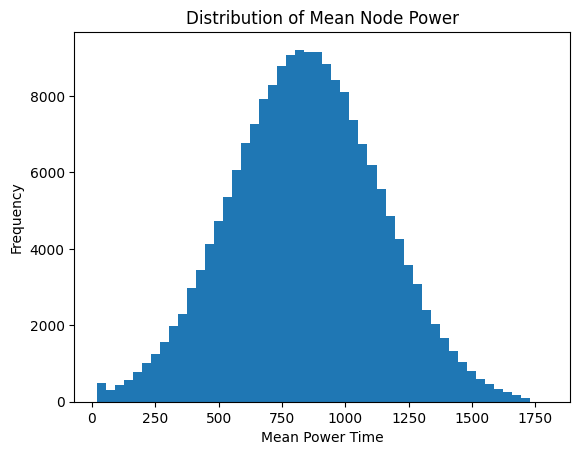

In [107]:
import matplotlib.pyplot as plt

synthetic_df['mean_node_power'].plot.hist(bins=50)
plt.title('Distribution of Mean Node Power')
plt.xlabel('Mean Power Time')
plt.ylabel('Frequency')
plt.show()

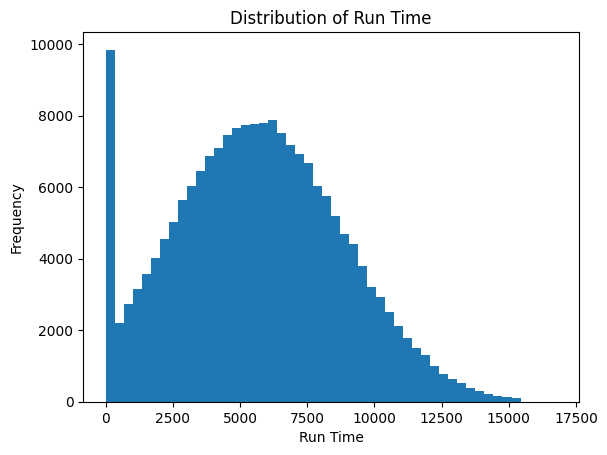

In [108]:
import matplotlib.pyplot as plt

synthetic_df['run_time'].plot.hist(bins=50)
plt.title('Distribution of Run Time')
plt.xlabel('Run Time')
plt.ylabel('Frequency')
plt.show()

# Creating a synthetic dataset that has normally distributed node power and run time metrics

In [2]:
import pandas as pd
file_path = 'clean_data.csv'

# Read CSV and ensure datetime columns are parsed correctly
time_columns = ['submit_time', 'eligible_time', 'start_time', 'end_time', 'wait_time']
df = pd.read_csv('clean_data.csv', parse_dates=time_columns)
# Now 'df' contains the data from the second sheet

/tmp/ipykernel_11217/4086838479.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('clean_data.csv', parse_dates=time_columns)


In [3]:
import numpy as np
from scipy import stats
import pandas as pd

def generate_synthetic_data(size=191315, seed=42):
    """
    Generate synthetic data with normal distributions based on original dataset parameters
    """
    np.random.seed(seed)
    
    # Generate synthetic mean_node_power
    mean_power = 841.26
    std_power = 369.34
    synthetic_power = np.random.normal(mean_power, std_power, size)
    synthetic_power = np.clip(synthetic_power, 20, 2440)
    
    # Generate synthetic run_time
    mean_time = 5615.28
    std_time = 16328.28 / 3  # Reducing std to keep values more reasonable
    synthetic_time = np.random.normal(mean_time, std_time, size)
    synthetic_time = np.clip(synthetic_time, 1, 125311)
    
    # Create DataFrame
    df = pd.DataFrame({
        'mean_node_power': synthetic_power,
        'run_time': synthetic_time
    })
    
    # Calculate statistics
    stats_dict = {
        'mean_node_power': {
            'mean': df['mean_node_power'].mean(),
            'std': df['mean_node_power'].std(),
            'skewness': stats.skew(df['mean_node_power']),
            'normality_pvalue': stats.normaltest(df['mean_node_power']).pvalue
        },
        'run_time': {
            'mean': df['run_time'].mean(),
            'std': df['run_time'].std(),
            'skewness': stats.skew(df['run_time']),
            'normality_pvalue': stats.normaltest(df['run_time']).pvalue
        }
    }
    
    return df, stats_dict

# Generate the data
synthetic_df, statistics = generate_synthetic_data()

# The resulting synthetic_df will have normally distributed values 
# while maintaining reasonable ranges based on the original data

In [4]:
import numpy as np
from scipy import stats
import pandas as pd

def generate_more_normal_data(size=191315, seed=42):
    """
    Generate highly normal synthetic data using transformations and precise controls
    """
    np.random.seed(seed)
    
    # Generate base normal distributions
    # Using smaller std to ensure better control
    mean_power = 841.26
    std_power = 369.34 * 0.8  # Reducing std for tighter control
    
    mean_time = 5615.28
    std_time = 16328.28 * 0.2  # Significantly reducing std for better normality
    
    # Generate initial normal distributions
    synthetic_power = np.random.normal(mean_power, std_power, size)
    synthetic_time = np.random.normal(mean_time, std_time, size)
    
    # Apply z-score based clipping to maintain normality
    z_threshold = 3
    power_zscore = np.abs(stats.zscore(synthetic_power))
    time_zscore = np.abs(stats.zscore(synthetic_time))
    
    synthetic_power = synthetic_power[power_zscore < z_threshold]
    synthetic_time = synthetic_time[time_zscore < z_threshold]
    
    # Ensure positive values while maintaining normality
    synthetic_power = np.maximum(synthetic_power, 20)
    synthetic_time = np.maximum(synthetic_time, 1)
    
    # Resize to match original size (to replace filtered values)
    while len(synthetic_power) < size:
        additional = np.random.normal(mean_power, std_power, size - len(synthetic_power))
        additional = additional[additional > 20]
        synthetic_power = np.concatenate([synthetic_power, additional])
    
    while len(synthetic_time) < size:
        additional = np.random.normal(mean_time, std_time, size - len(synthetic_time))
        additional = additional[additional > 1]
        synthetic_time = np.concatenate([synthetic_time, additional])
    
    # Trim to exact size
    synthetic_power = synthetic_power[:size]
    synthetic_time = synthetic_time[:size]
    
    # Create DataFrame
    df = pd.DataFrame({
        'mean_node_power': synthetic_power,
        'run_time': synthetic_time
    })
    
    # Calculate comprehensive statistics
    stats_dict = {
        'mean_node_power': {
            'mean': df['mean_node_power'].mean(),
            'std': df['mean_node_power'].std(),
            'skewness': stats.skew(df['mean_node_power']),
            'kurtosis': stats.kurtosis(df['mean_node_power']),
            'normality_pvalue': stats.normaltest(df['mean_node_power']).pvalue,
            'shapiro_pvalue': stats.shapiro(df['mean_node_power'][:5000])[1]  # Shapiro test limited to 5000 samples
        },
        'run_time': {
            'mean': df['run_time'].mean(),
            'std': df['run_time'].std(),
            'skewness': stats.skew(df['run_time']),
            'kurtosis': stats.kurtosis(df['run_time']),
            'normality_pvalue': stats.normaltest(df['run_time']).pvalue,
            'shapiro_pvalue': stats.shapiro(df['run_time'][:5000])[1]  # Shapiro test limited to 5000 samples
        }
    }
    
    return df, stats_dict

# Generate the data
synthetic_df, statistics = generate_more_normal_data()

# The resulting synthetic_df will have highly normal distributions
# while maintaining reasonable ranges based on the original data

In [5]:
synthetic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191315 entries, 0 to 191314
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   mean_node_power  191315 non-null  float64
 1   run_time         191315 non-null  float64
dtypes: float64(2)
memory usage: 2.9 MB


In [109]:
statistics

{'mean_node_power': {'mean': np.float64(841.8522621502472),
  'std': np.float64(291.60026007901104),
  'skewness': np.float64(0.0029590981976692185),
  'kurtosis': np.float64(-0.17772028519250638),
  'normality_pvalue': np.float64(8.645727966533133e-67),
  'shapiro_pvalue': np.float64(0.0064137596346418935)},
 'run_time': {'mean': np.float64(5666.123553485529),
  'std': np.float64(3116.1839635410265),
  'skewness': np.float64(0.17556794025443717),
  'kurtosis': np.float64(-0.4324339833481221),
  'normality_pvalue': np.float64(0.0),
  'shapiro_pvalue': np.float64(3.7037207621215293e-20)}}

# Creating a representative HPC job trace that has normalized runtimes and power data
synthetic dataset

In [71]:
import pandas as pd
file_path = 'clean_data.csv'

# Read CSV and ensure datetime columns are parsed correctly
time_columns = ['submit_time', 'eligible_time', 'start_time', 'end_time', 'wait_time']
df = pd.read_csv('clean_data.csv', parse_dates=time_columns)
# Now 'df' contains the data from the second sheet

/tmp/ipykernel_11217/4086838479.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('clean_data.csv', parse_dates=time_columns)


In [72]:
df.columns

Index(['job_id', 'job_state', 'submit_time', 'eligible_time', 'start_time',
       'end_time', 'run_time', 'wait_time', 'cores_per_task', 'shared',
       'partition', 'priority', 'num_tasks', 'state_reason', 'num_cores_alloc',
       'num_nodes_alloc', 'num_gpus_alloc', 'mem_alloc', 'mean_node_power',
       'mean_cpu_power', 'mean_mem_power'],
      dtype='object')

In [73]:
import numpy as np
from scipy import stats
import pandas as pd
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer

def normalize_hpc_metrics(df, seed=42):
    """
    Generate normalized run_time and mean_node_power while preserving job characteristics relationships
    and keeping all original columns
    """
    np.random.seed(seed)
    
    # Select features that influence run_time and power
    features = ['cores_per_task', 'num_cores_alloc', 'num_nodes_alloc', 
               'num_gpus_alloc', 'mem_alloc', 'num_tasks']
    
    X = df[features].copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Base scores for power
    base_scores_power = (
        0.3 * X_scaled[:, 0] +  # cores_per_task
        0.3 * X_scaled[:, 1] +  # num_cores_alloc
        0.2 * X_scaled[:, 2] +  # num_nodes_alloc
        0.1 * X_scaled[:, 3] +  # num_gpus_alloc
        0.1 * X_scaled[:, 4]    # mem_alloc
    )
    
    # Base scores for run time
    base_scores_time = (
        0.2 * X_scaled[:, 0] +   # cores_per_task
        0.2 * X_scaled[:, 1] +   # num_cores_alloc
        0.2 * X_scaled[:, 2] +   # num_nodes_alloc
        0.2 * X_scaled[:, 3] +   # num_gpus_alloc
        0.2 * X_scaled[:, 4]     # mem_alloc
    )
    
    def generate_normalized_run_time(base, original_mean, original_std, min_val):
        pt = PowerTransformer(method='yeo-johnson', standardize=True)
        base_transformed = pt.fit_transform(base.reshape(-1, 1)).ravel()
        
        qt = QuantileTransformer(output_distribution='normal', random_state=seed)
        base_transformed = qt.fit_transform(base_transformed.reshape(-1, 1)).ravel()
        
        base_percentiles = stats.rankdata(base_transformed) / len(base_transformed)
        
        normal_dist = np.random.normal(original_mean, original_std/4, len(base))
        normal_dist.sort()
        
        mapped_values = np.interp(base_percentiles, 
                                np.linspace(0, 1, len(base)), 
                                normal_dist)
        
        noise = np.random.normal(0, original_std/30, len(mapped_values))
        mapped_values += noise
        
        mapped_values = np.clip(mapped_values, min_val, original_mean + 2*original_std)
        
        return mapped_values
    
    def generate_normalized_power(base, original_mean, original_std, min_val):
        base_percentiles = stats.rankdata(base) / len(base)
        normal_dist = np.random.normal(original_mean, original_std/2, len(base))
        normal_dist.sort()
        
        mapped_values = np.interp(base_percentiles, 
                                np.linspace(0, 1, len(base)), 
                                normal_dist)
        
        return np.maximum(mapped_values, min_val)
    
    # Generate new normalized values
    new_run_time = generate_normalized_run_time(
        base_scores_time,
        df['run_time'].mean(),
        df['run_time'].std(),
        1.0
    )
    
    new_node_power = generate_normalized_power(
        base_scores_power,
        df['mean_node_power'].mean(),
        df['mean_node_power'].std(),
        20.0
    )
    
    # Create output DataFrame with ALL original columns plus normalized values
    result_df = df.copy()  # Copy all original columns
    
    # Add normalized columns
    result_df['normalized_run_time'] = new_run_time
    result_df['normalized_node_power'] = new_node_power
    
    # Calculate statistics
    stats_dict = {
        'run_time': {
            'original_mean': df['run_time'].mean(),
            'original_std': df['run_time'].std(),
            'original_skew': stats.skew(df['run_time']),
            'normalized_mean': new_run_time.mean(),
            'normalized_std': new_run_time.std(),
            'normalized_skew': stats.skew(new_run_time),
            'correlation_with_cores': np.corrcoef(df['cores_per_task'], new_run_time)[0,1],
            'correlation_with_nodes': np.corrcoef(df['num_nodes_alloc'], new_run_time)[0,1]
        },
        'node_power': {
            'original_mean': df['mean_node_power'].mean(),
            'original_std': df['mean_node_power'].std(),
            'original_skew': stats.skew(df['mean_node_power']),
            'normalized_mean': new_node_power.mean(),
            'normalized_std': new_node_power.std(),
            'normalized_skew': stats.skew(new_node_power),
            'correlation_with_cores': np.corrcoef(df['cores_per_task'], new_node_power)[0,1],
            'correlation_with_nodes': np.corrcoef(df['num_nodes_alloc'], new_node_power)[0,1]
        }
    }
    
    return result_df, stats_dict

In [74]:
# Usage example:
normalized_df, statistics = normalize_hpc_metrics(df)
print("Statistics:", statistics)
# 
# To verify correlations between job characteristics and normalized values:
# print(normalized_df.corr()[['normalized_run_time', 'normalized_node_power']])

Statistics: {'run_time': {'original_mean': np.float64(5615.282685623187), 'original_std': np.float64(16328.279163786876), 'original_skew': np.float64(3.788226917247274), 'normalized_mean': np.float64(5767.922732325875), 'normalized_std': np.float64(3778.010237869221), 'normalized_skew': np.float64(0.34620117065858413), 'correlation_with_cores': np.float64(0.610215370122973), 'correlation_with_nodes': np.float64(0.4368481306541518)}, 'node_power': {'original_mean': np.float64(841.2634808153343), 'original_std': np.float64(369.3438027971018), 'original_skew': np.float64(1.897939580783454), 'normalized_mean': np.float64(840.158333230392), 'normalized_std': np.float64(183.09707352275157), 'normalized_skew': np.float64(0.0032038219195346775), 'correlation_with_cores': np.float64(0.6572005698769959), 'correlation_with_nodes': np.float64(0.40203127299050506)}}


In [75]:
normalized_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191315 entries, 0 to 191314
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   job_id                 191315 non-null  int64         
 1   job_state              191315 non-null  object        
 2   submit_time            191315 non-null  datetime64[ns]
 3   eligible_time          191315 non-null  datetime64[ns]
 4   start_time             191315 non-null  datetime64[ns]
 5   end_time               191315 non-null  datetime64[ns]
 6   run_time               191315 non-null  int64         
 7   wait_time              191315 non-null  object        
 8   cores_per_task         191315 non-null  int64         
 9   shared                 191315 non-null  int64         
 10  partition              191315 non-null  int64         
 11  priority               191315 non-null  int64         
 12  num_tasks              191315 non-null  floa

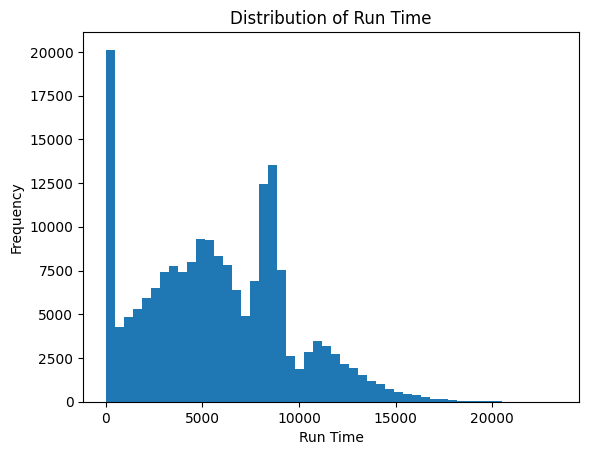

In [76]:
import matplotlib.pyplot as plt

normalized_df['normalized_run_time'].plot.hist(bins=50)
plt.title('Distribution of Run Time')
plt.xlabel('Run Time')
plt.ylabel('Frequency')
plt.show()

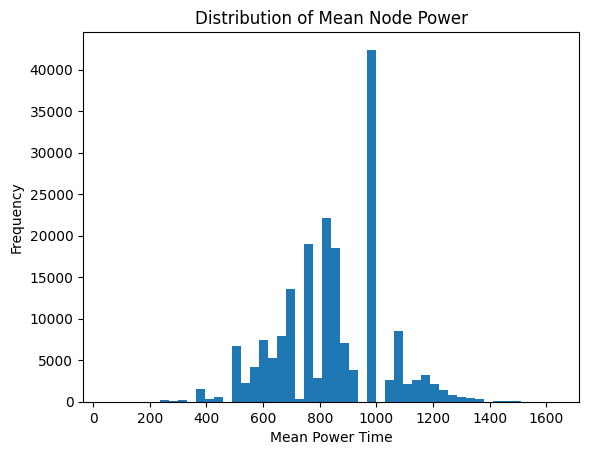

In [77]:
import matplotlib.pyplot as plt

normalized_df['normalized_node_power'].plot.hist(bins=50)
plt.title('Distribution of Mean Node Power')
plt.xlabel('Mean Power Time')
plt.ylabel('Frequency')
plt.show()

In [78]:
# print(normalized_df.head())
# print(normalized_df.isna().sum())

In [79]:
print('Skewness of Normalized Node Power: ', normalized_df['normalized_node_power'].skew(),'\n','Skewness of Normalized  Run Time: ', normalized_df['normalized_run_time'].skew())

Skewness of Normalized Node Power:  0.003203847039264054 
 Skewness of Normalized  Run Time:  0.3462038850665428


In [80]:
normalized_df = normalized_df.drop('run_time', axis=1)
normalized_df = normalized_df.drop('mean_node_power', axis=1)
normalized_df = normalized_df.drop('partition', axis=1)

normalized_df = normalized_df.rename(columns={'normalized_run_time': 'run_time'})
normalized_df = normalized_df.rename(columns={'normalized_node_power': 'mean_node_power'})

In [82]:
normalized_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191315 entries, 0 to 191314
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   job_id           191315 non-null  int64         
 1   job_state        191315 non-null  object        
 2   submit_time      191315 non-null  datetime64[ns]
 3   eligible_time    191315 non-null  datetime64[ns]
 4   start_time       191315 non-null  datetime64[ns]
 5   end_time         191315 non-null  datetime64[ns]
 6   wait_time        191315 non-null  object        
 7   cores_per_task   191315 non-null  int64         
 8   shared           191315 non-null  int64         
 9   priority         191315 non-null  int64         
 10  num_tasks        191315 non-null  float64       
 11  state_reason     191315 non-null  object        
 12  num_cores_alloc  191315 non-null  int64         
 13  num_nodes_alloc  191315 non-null  int64         
 14  num_gpus_alloc   191

In [83]:
# Save DataFrame to CSV
normalized_df.to_csv('normalized_data.csv', index=False, date_format='%Y-%m-%d %H:%M:%S')

In [ ]:
import pandas as pd

# Define the file path
file_path = 'normalized_data.csv'

# Read the CSV file and ensure datetime columns are parsed correctly
time_columns = ['submit_time', 'eligible_time', 'start_time', 'end_time', 'wait_time']
df_normalized = pd.read_csv(file_path, parse_dates=time_columns)

# Display the first few rows of the dataframe
# print(df_normalized.head())

   job_id  job_state         submit_time       eligible_time  \
0       1    TIMEOUT 2020-05-05 15:55:59 2020-05-05 15:55:59   
1       2    TIMEOUT 2020-05-05 16:01:00 2020-05-05 16:01:00   
2       3    TIMEOUT 2020-05-05 16:21:46 2020-05-05 16:21:46   
3       4    TIMEOUT 2020-05-05 20:53:46 2020-05-05 20:53:46   
4       5  COMPLETED 2020-05-06 06:41:32 2020-05-06 06:41:32   

           start_time wait_time  cores_per_task  shared  priority  num_tasks  \
0 2020-05-05 15:56:00   86407.0              32       1         1  12.852698   
1 2020-05-05 16:01:00   86407.0              32       1         1  12.852698   
2 2020-05-05 16:21:47   86420.0              32       1         1  12.852698   
3 2020-05-05 20:53:46   82826.0               1       1         1  12.852698   
4 2020-05-06 06:41:51   13243.0               4       1         1  12.852698   

  state_reason  num_cores_alloc  num_nodes_alloc  num_gpus_alloc  mem_alloc  \
0    TimeLimit              128                1       

/tmp/ipykernel_17930/2597580959.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_normalized = pd.read_csv(file_path, parse_dates=time_columns)


In [25]:
df_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191315 entries, 0 to 191314
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   job_id           191315 non-null  int64         
 1   job_state        191315 non-null  object        
 2   submit_time      191315 non-null  datetime64[ns]
 3   eligible_time    191315 non-null  datetime64[ns]
 4   start_time       191315 non-null  datetime64[ns]
 5   end_time         191315 non-null  datetime64[ns]
 6   wait_time        191315 non-null  object        
 7   cores_per_task   191315 non-null  int64         
 8   shared           191315 non-null  int64         
 9   priority         191315 non-null  int64         
 10  num_tasks        191315 non-null  float64       
 11  state_reason     191315 non-null  object        
 12  num_cores_alloc  191315 non-null  int64         
 13  num_nodes_alloc  191315 non-null  int64         
 14  num_gpus_alloc   191

In [26]:
df_normalized.drop(columns=['end_time'], inplace=True)
df_normalized['run_time'] = pd.to_timedelta(df_normalized['run_time'], unit='s')
df_normalized['end_time'] = df_normalized['start_time'] + df_normalized['run_time']


In [27]:
df_normalized['run_time'] = df_normalized['run_time'].dt.total_seconds().astype('float64')

In [32]:
df_normalized.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191315 entries, 0 to 191314
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   job_id           191315 non-null  int64         
 1   job_state        191315 non-null  object        
 2   submit_time      191315 non-null  datetime64[ns]
 3   eligible_time    191315 non-null  datetime64[ns]
 4   start_time       191315 non-null  datetime64[ns]
 5   wait_time        191315 non-null  object        
 6   cores_per_task   191315 non-null  int64         
 7   shared           191315 non-null  int64         
 8   priority         191315 non-null  int64         
 9   num_tasks        191315 non-null  float64       
 10  state_reason     191315 non-null  object        
 11  num_cores_alloc  191315 non-null  int64         
 12  num_nodes_alloc  191315 non-null  int64         
 13  num_gpus_alloc   191315 non-null  int64         
 14  mem_alloc        191

In [29]:
# df_run_time = df_normalized[['start_time', 'end_time', 'run_time']].copy()
# df_run_time['calc_run_time'] =  df_normalized['end_time'] - df_normalized['start_time']
# df_run_time['calc_run_time'] = df_run_time['calc_run_time'].dt.total_seconds()
# df_run_time['diff'] = df_run_time['run_time'] - df_run_time['calc_run_time']

In [30]:
# df_run_time['diff'].describe()

count    191315.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: diff, dtype: float64

In [33]:
# Save DataFrame to CSV
df_normalized.to_csv('normalized_data.csv', index=False, date_format='%Y-%m-%d %H:%M:%S')

# Deleting outliers of job run times

In [25]:
import pandas as pd

# Define the file path
file_path = 'normalized_data.csv'

# Read the CSV file and ensure datetime columns are parsed correctly
time_columns = ['submit_time', 'eligible_time', 'start_time', 'end_time', 'wait_time']
df = pd.read_csv(file_path, parse_dates=time_columns)

# Display the first few rows of the dataframe
# print(df_normalized.head())

/tmp/ipykernel_17930/2702680493.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, parse_dates=time_columns)


In [26]:
import scipy.stats as stats
df['run_time_z'] = stats.zscore(df['run_time'])
extreme_jobs = df[df['run_time_z'].abs() > 3]
print(extreme_jobs[['job_id', 'run_time', 'run_time_z']])

# First remove the outliers (keeping only jobs with z-score <= 3)
df_clean = df[df['run_time_z'].abs() <= 3].copy()

# Reset the index to get sequential numbering
df_clean = df_clean.reset_index(drop=True)

# Create new sequential job_ids (starting from 1)
df_clean['job_id'] = df_clean.index + 1

# If you want to verify the changes:
print(f"Original dataset size: {len(df)}")
print(f"Cleaned dataset size: {len(df_clean)}")
print("\nFirst few rows of cleaned dataset:")
print(df_clean[['job_id', 'run_time']].head())

        job_id      run_time  run_time_z
2089      2090  17031.873112    3.028612
4293      4294  17097.918964    3.046320
4340      4341  17048.328616    3.033024
4410      4411  17067.002660    3.038031
5125      5126  17066.137014    3.037799
...        ...           ...         ...
120036  120037  16962.907360    3.010121
125025  125026  16945.106493    3.005348
131119  131120  16991.386770    3.017757
139282  139283  17053.830807    3.034499
188637  188638  16925.192562    3.000009

[69 rows x 3 columns]
Original dataset size: 190827
Cleaned dataset size: 190758

First few rows of cleaned dataset:
   job_id      run_time
0       1   8669.464517
1       2   7388.687564
2       3   8201.023267
3       4  13302.112705
4       5   1651.941251


<Axes: >

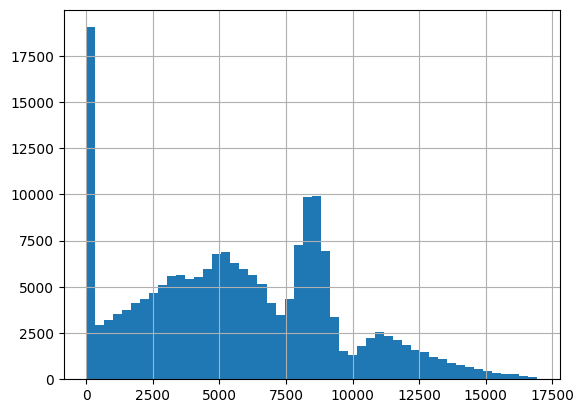

In [29]:
df_clean['run_time'].hist(bins=50)
# plt.title('Distribution of Run Time')

In [28]:
import pandas as pd
import numpy as np

def sample_high_volume_minutes(df, sample_size=7, threshold_percentile=95):
    # Convert submit_time to minute-level granularity
    df['minute'] = df['submit_time'].dt.floor('T')
    
    # Count jobs per minute
    jobs_per_minute = df['minute'].value_counts()
    
    # Define high-volume threshold (e.g., 95th percentile of job counts)
    threshold = np.percentile(jobs_per_minute.values, threshold_percentile)
    
    # Initialize list to store sampled jobs
    sampled_jobs = []
    
    # Group by minute and process each group
    for minute, group in df.groupby('minute'):
        if len(group) > threshold:
            # If high-volume minute, take random sample
            sampled = group.sample(n=min(sample_size, len(group)), random_state=42)
            sampled_jobs.append(sampled)
        else:
            # If normal volume, keep all jobs
            sampled_jobs.append(group)
    
    # Combine all sampled jobs
    df_sampled = pd.concat(sampled_jobs)
    
    # Sort by submit time and reset index
    df_sampled = df_sampled.sort_values('submit_time').reset_index(drop=True)
    
    # Create new sequential job IDs
    df_sampled['job_id'] = df_sampled.index + 1
    
    return df_sampled

# Apply the sampling
df_sampled = sample_high_volume_minutes(
    df,
    sample_size=7,  # Number of jobs to keep per high-volume minute
    threshold_percentile=95  # Define high-volume as top 5% busy minutes
)

# Print statistics
print(f"Original dataset size: {len(df)}")
print(f"Sampled dataset size: {len(df_sampled)}")

# Get distribution of jobs per minute before and after
jobs_per_minute_before = df.groupby(df['submit_time'].dt.floor('T')).size()
jobs_per_minute_after = df_sampled.groupby(df_sampled['submit_time'].dt.floor('T')).size()

print("\nJobs per minute statistics:")
print("Before sampling:")
print(jobs_per_minute_before.describe())
print("\nAfter sampling:")
print(jobs_per_minute_after.describe())

/tmp/ipykernel_17930/3303392905.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['submit_time'].dt.floor('T')


Original dataset size: 190827
Sampled dataset size: 121521

Jobs per minute statistics:
Before sampling:
count    50494.000000
mean         3.779201
std         17.264504
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       1304.000000
dtype: float64

After sampling:
count    50494.000000
mean         2.406642
std          2.308404
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         10.000000
dtype: float64


/tmp/ipykernel_17930/3303392905.py:50: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  jobs_per_minute_before = df.groupby(df['submit_time'].dt.floor('T')).size()
/tmp/ipykernel_17930/3303392905.py:51: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  jobs_per_minute_after = df_sampled.groupby(df_sampled['submit_time'].dt.floor('T')).size()


In [30]:
df_sampled.to_csv('normalized_data.csv', index=False, date_format='%Y-%m-%d %H:%M:%S')

# job submit time data cleaning

In [5]:
import pandas as pd
# --- Data Loading and Preprocessing ---

file_path = '/home/abrar/Desktop/Code/Temporal HPC/normalized_data.csv'

# Load data
time_columns = ['submit_time', 'eligible_time', 'start_time', 'end_time', 'wait_time']
df = pd.read_csv(file_path, parse_dates=time_columns)

/tmp/ipykernel_27777/688705141.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, parse_dates=time_columns)


In [7]:
# Finiding missing dates

import pandas as pd

def find_missing_dates(df):
    # Ensure the submit_time column is in datetime format
    df['submit_time'] = pd.to_datetime(df['submit_time'])

    # Find the start and end dates
    start_date = df['submit_time'].min()
    end_date = df['submit_time'].max()

    # Create a date range with all dates between start and end dates
    date_range = pd.date_range(start=start_date, end=end_date)

    # Find missing dates by taking the difference between the date range and the unique submit_time values
    missing_dates = date_range[~date_range.isin(df['submit_time'].unique())]

    return missing_dates

missing_dates = find_missing_dates(df)
print(len(missing_dates), missing_dates)

160 DatetimeIndex(['2020-05-06 15:55:59', '2020-05-07 15:55:59',
               '2020-05-08 15:55:59', '2020-05-09 15:55:59',
               '2020-05-10 15:55:59', '2020-05-11 15:55:59',
               '2020-05-12 15:55:59', '2020-05-13 15:55:59',
               '2020-05-14 15:55:59', '2020-05-15 15:55:59',
               ...
               '2020-10-03 15:55:59', '2020-10-04 15:55:59',
               '2020-10-05 15:55:59', '2020-10-06 15:55:59',
               '2020-10-07 15:55:59', '2020-10-08 15:55:59',
               '2020-10-09 15:55:59', '2020-10-10 15:55:59',
               '2020-10-11 15:55:59', '2020-10-12 15:55:59'],
              dtype='datetime64[ns]', length=160, freq='D')


In [4]:
start_date = df['submit_time'].min()
end_date = df['submit_time'].max()
print("Start Date:", start_date)
print("End Date:", end_date)

Start Date: 2022-01-01 00:00:00
End Date: 2022-01-05 00:00:00


In [10]:
import pandas as pd
import numpy as np
from datetime import timedelta

def fill_date_gaps(df):
    """
    Fill gaps in submit_time dates and generate representative data for other columns.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame with HPC job data
    
    Returns:
    pd.DataFrame: DataFrame with filled gaps and generated data
    """
    # Create date range from min to max submit_time
    min_date = df['submit_time'].min()
    max_date = df['submit_time'].max()
    complete_dates = pd.date_range(start=min_date, end=max_date, freq='D')
    
    # Find missing dates
    existing_dates = pd.to_datetime(df['submit_time'].dt.date).unique()
    missing_dates = pd.DatetimeIndex(set(complete_dates) - set(existing_dates))
    
    if len(missing_dates) == 0:
        return df
    
    # Create synthetic data for missing dates
    synthetic_records = []
    
    for missing_date in missing_dates:
        # Get the average number of jobs per day in the original data
        jobs_per_day = df.groupby(df['submit_time'].dt.date).size().mean()
        num_synthetic_jobs = int(np.random.normal(jobs_per_day, jobs_per_day * 0.1))  # Add some variation
        num_synthetic_jobs = max(1, num_synthetic_jobs)  # Ensure at least one job
        
        for _ in range(num_synthetic_jobs):
            # Create a new record
            synthetic_record = {}
            
            # Generate submit_time within the missing date
            synthetic_record['submit_time'] = pd.Timestamp(missing_date) + pd.Timedelta(
                seconds=np.random.randint(0, 86400)  # Random time within the day
            )
            
            # Generate representative data for other columns
            for column in df.columns:
                if column == 'submit_time':
                    continue
                    
                if column == 'job_id':
                    # Generate unique job ID
                    synthetic_record[column] = df['job_id'].max() + len(synthetic_records) + 1
                    
                elif df[column].dtype == 'datetime64[ns]':
                    # Handle other datetime columns relative to submit_time
                    if column == 'eligible_time':
                        delay = pd.Timedelta(seconds=np.random.choice(
                            (df['eligible_time'] - df['submit_time']).dt.total_seconds()
                        ))
                        synthetic_record[column] = synthetic_record['submit_time'] + delay
                    elif column == 'start_time':
                        delay = pd.Timedelta(seconds=np.random.choice(
                            (df['start_time'] - df['eligible_time']).dt.total_seconds()
                        ))
                        synthetic_record[column] = synthetic_record['eligible_time'] + delay
                    elif column == 'end_time':
                        runtime = np.random.choice(df['run_time'])
                        synthetic_record[column] = synthetic_record['start_time'] + pd.Timedelta(seconds=runtime)
                
                elif pd.api.types.is_numeric_dtype(df[column].dtype):
                    # Generate numeric values based on distribution of existing data
                    mean = df[column].mean()
                    std = df[column].std()
                    if pd.api.types.is_integer_dtype(df[column].dtype):
                        value = int(np.random.normal(mean, std))
                        # Ensure non-negative for counts/allocations
                        value = max(0, value)
                        synthetic_record[column] = value
                    else:
                        value = np.random.normal(mean, std)
                        # Ensure non-negative for measurements
                        value = max(0, value)
                        synthetic_record[column] = value
                
                elif pd.api.types.is_object_dtype(df[column].dtype):
                    # Sample categorical values based on their frequency
                    synthetic_record[column] = np.random.choice(
                        df[column].dropna().unique(),
                        p=df[column].value_counts(normalize=True).values
                    )
                
            synthetic_records.append(synthetic_record)
    
    # Create DataFrame with synthetic records
    synthetic_df = pd.DataFrame(synthetic_records)
    
    # Combine original and synthetic data
    combined_df = pd.concat([df, synthetic_df], ignore_index=True)
    
    # Sort by submit_time
    combined_df = combined_df.sort_values('submit_time').reset_index(drop=True)
    
    return combined_df

def verify_gaps(df):
    """
    Verify that there are no gaps in the date range.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    
    Returns:
    bool: True if no gaps, False otherwise
    """
    date_range = pd.date_range(
        start=df['submit_time'].min().date(),
        end=df['submit_time'].max().date(),
        freq='D'
    )
    existing_dates = pd.to_datetime(df['submit_time'].dt.date).unique()
    missing_dates = set(date_range) - set(existing_dates)
    return len(missing_dates) == 0

# Usage example:

# Read your dataset
df = pd.read_csv('normalized_data.csv', parse_dates=['submit_time', 'eligible_time', 'start_time', 'end_time'])

# Fill gaps in the dataset
df_filled = fill_date_gaps(df)

# Verify no gaps remain
if verify_gaps(df_filled):
    print("All gaps have been filled successfully!")
else:
    print("Some gaps still remain in the dataset.")

# Check the number of added records
print(f"Original records: {len(df)}")
print(f"Records after filling gaps: {len(df_filled)}")

All gaps have been filled successfully!
Original records: 191315
Records after filling gaps: 390134


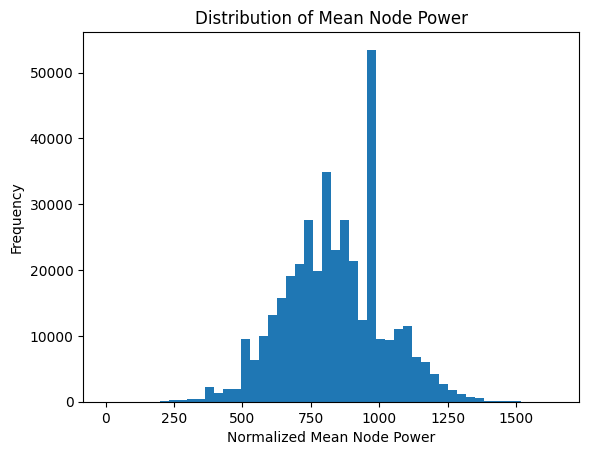

In [12]:
import matplotlib.pyplot as plt

df_filled['mean_node_power'].plot.hist(bins=50)
plt.title('Distribution of Mean Node Power')
plt.xlabel('Normalized Mean Node Power')
plt.ylabel('Frequency')
plt.show()

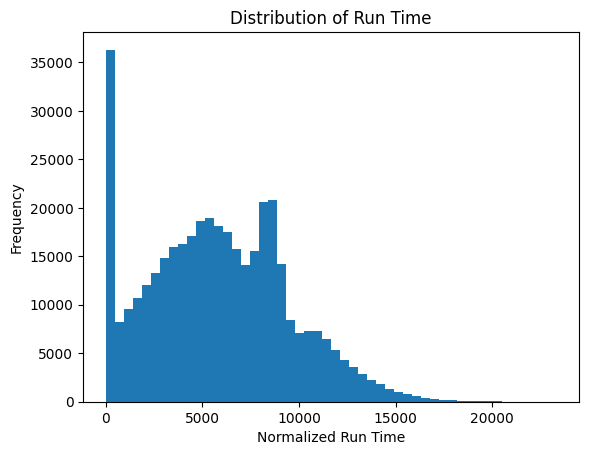

In [13]:
import matplotlib.pyplot as plt

df_filled['run_time'].plot.hist(bins=50)
plt.title('Distribution of Run Time')
plt.xlabel('Normalized Run Time')
plt.ylabel('Frequency')
plt.show()

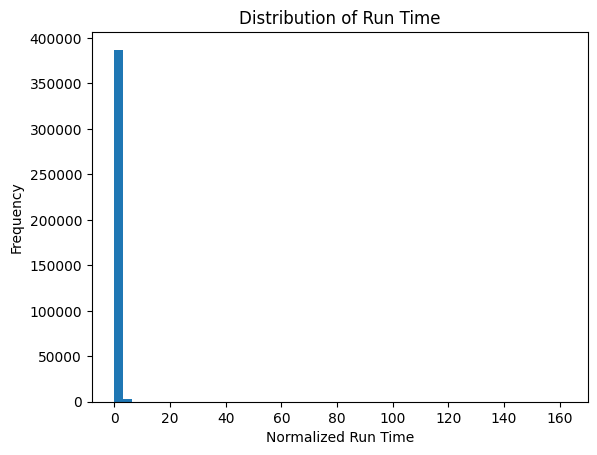

In [14]:
import matplotlib.pyplot as plt

df_filled['num_nodes_alloc'].plot.hist(bins=50)
plt.title('Distribution of Run Time')
plt.xlabel('Normalized Run Time')
plt.ylabel('Frequency')
plt.show()

In [23]:
df_filled.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390134 entries, 0 to 390133
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype          
---  ------           --------------   -----          
 0   job_id           390134 non-null  int64          
 1   job_state        390134 non-null  object         
 2   submit_time      390134 non-null  datetime64[ns] 
 3   eligible_time    390134 non-null  datetime64[ns] 
 4   start_time       390134 non-null  datetime64[ns] 
 5   wait_time        390134 non-null  float64        
 6   cores_per_task   390134 non-null  int64          
 7   shared           390134 non-null  int64          
 8   priority         390134 non-null  int64          
 9   num_tasks        390134 non-null  float64        
 10  state_reason     390134 non-null  object         
 11  num_cores_alloc  390134 non-null  int64          
 12  num_nodes_alloc  390134 non-null  int64          
 13  num_gpus_alloc   390134 non-null  int64          
 14  mem_

In [20]:
df_filled.drop(columns=['end_time'], inplace=True)
df_filled['run_time'] = pd.to_timedelta(df_filled['run_time'], unit='s')
df_filled['end_time'] = df_filled['start_time'] + df_filled['run_time']

In [22]:
df_run_time = df_filled[['start_time', 'end_time', 'run_time']].copy()
df_run_time['calc_run_time'] =  df_filled['end_time'] - df_filled['start_time']
df_run_time['calc_run_time'] = df_filled['calc_run_time'].dt.total_seconds()
df_run_time['diff'] = df_run_time['run_time'] - df_run_time['calc_run_time']
# df_run_time['diff'] = df_run_time['run_time'] - df_run_time['calc_run_time']

KeyError: 'calc_run_time'

In [15]:
# Save DataFrame to CSV
df_filled.to_csv('normalized_filled_data.csv', index=False, date_format='%Y-%m-%d %H:%M:%S')

# Different form of normalization

This does not filter down the dataset. Rather adds new columns of the normalized metrics" 

In [26]:
# First create normalized columns
df['normalized_run_time'] = np.log(df['run_time'])
df['normalized_power'] = np.log(df['mean_node_power'])

# Then test normality
from scipy import stats
print("Normality test for power:", stats.shapiro(df['normalized_power']))
print("Normality test for time:", stats.shapiro(df['normalized_run_time']))


# df['normalized_run_time'] = np.log(df['normalized_run_time'])
# df['normalized_power'] = np.log(df['mean_node_power'])

Normality test for power: ShapiroResult(statistic=np.float64(0.905472341852645), pvalue=np.float64(2.119825986448507e-124))
Normality test for time: ShapiroResult(statistic=np.float64(0.9516095443201341), pvalue=np.float64(1.0790001338164083e-105))


/home/abrar/Desktop/Code/Temporal HPC/myenv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 191315.
  res = hypotest_fun_out(*samples, **kwds)


In [31]:
from scipy import stats
df['normalized_power'] = stats.boxcox(df['mean_node_power'])[0]
df['normalized_run_time'] = stats.boxcox(df['run_time'])[0]

# Test normality
print("Normality test for power:", stats.shapiro(df['normalized_power']))
print("Normality test for time:", stats.shapiro(df['normalized_run_time']))

Normality test for power: ShapiroResult(statistic=np.float64(0.9038309582887434), pvalue=np.float64(6.682516639625073e-125))
Normality test for time: ShapiroResult(statistic=np.float64(0.950501124882523), pvalue=np.float64(2.664427508973189e-106))


/home/abrar/Desktop/Code/Temporal HPC/myenv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 191315.
  res = hypotest_fun_out(*samples, **kwds)


In [34]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
df[['normalized_power', 'normalized_run_time']] = pt.fit_transform(df[['mean_node_power', 'run_time']])

# Test normality
print("Normality test for power:", stats.shapiro(df['normalized_power']))
print("Normality test for time:", stats.shapiro(df['normalized_run_time']))

Normality test for power: ShapiroResult(statistic=np.float64(0.9042381332431466), pvalue=np.float64(8.883905560019901e-125))
Normality test for time: ShapiroResult(statistic=np.float64(0.9431056775697326), pvalue=np.float64(4.487711031964779e-110))


/home/abrar/Desktop/Code/Temporal HPC/myenv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 191315.
  res = hypotest_fun_out(*samples, **kwds)


In [37]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')
df[['normalized_power', 'normalized_run_time']] = qt.fit_transform(df[['mean_node_power', 'run_time']])

# Test normality
print("Normality test for power:", stats.shapiro(df['normalized_power']))
print("Normality test for time:", stats.shapiro(df['normalized_run_time']))

Normality test for power: ShapiroResult(statistic=np.float64(0.9991311283035449), pvalue=np.float64(6.762103311319103e-26))
Normality test for time: ShapiroResult(statistic=np.float64(0.7599448988511768), pvalue=np.float64(5.148566029768089e-153))


/home/abrar/Desktop/Code/Temporal HPC/myenv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 191315.
  res = hypotest_fun_out(*samples, **kwds)


In [41]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer

# Two-step transformation
rs = RobustScaler()
qt = QuantileTransformer(output_distribution='normal')

# Transform power
scaled_power = rs.fit_transform(df[['mean_node_power']])
df['normalized_power'] = qt.fit_transform(scaled_power)

# Transform time
scaled_time = rs.fit_transform(df[['run_time']])
df['normalized_run_time'] = qt.fit_transform(scaled_time)

print("Normality test for power:", stats.shapiro(df['normalized_power']))
print("Normality test for time:", stats.shapiro(df['normalized_run_time']))

Normality test for power: ShapiroResult(statistic=np.float64(0.9990878400454394), pvalue=np.float64(1.5746894327589537e-26))
Normality test for time: ShapiroResult(statistic=np.float64(0.756827764791606), pvalue=np.float64(1.9702213971603499e-153))


/home/abrar/Desktop/Code/Temporal HPC/myenv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 191315.
  res = hypotest_fun_out(*samples, **kwds)


In [55]:
from scipy.stats import norm
from scipy.stats import rankdata

def gaussian_copula_transform(x):
    ranks = rankdata(x)
    u = ranks / (len(x) + 1)  # Uniform scores
    return norm.ppf(u)  # Convert to normal

df['normalized_power'] = gaussian_copula_transform(df['mean_node_power'])
df['normalized_run_time'] = gaussian_copula_transform(df['run_time'])

print("Normality test for power:", stats.shapiro(df['normalized_power']))
print("Normality test for time:", stats.shapiro(df['normalized_run_time']))

Normality test for power: ShapiroResult(statistic=np.float64(0.9995223151358036), pvalue=np.float64(9.004718509508408e-19))
Normality test for time: ShapiroResult(statistic=np.float64(0.973810279059932), pvalue=np.float64(6.677877451336507e-90))


/home/abrar/Desktop/Code/Temporal HPC/myenv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 191315.
  res = hypotest_fun_out(*samples, **kwds)


In [49]:
def rint_transform(x):
    n = len(x)
    r = rankdata(x)
    return norm.ppf((r - 0.5) / n)

df['normalized_power'] = rint_transform(df['mean_node_power'])
df['normalized_run_time'] = rint_transform(df['run_time'])

print("Normality test for power:", stats.shapiro(df['normalized_power']))
print("Normality test for time:", stats.shapiro(df['normalized_run_time']))

Normality test for power: ShapiroResult(statistic=np.float64(0.9995229921096012), pvalue=np.float64(9.330482092787228e-19))
Normality test for time: ShapiroResult(statistic=np.float64(0.9738099424644983), pvalue=np.float64(6.673005462905884e-90))


/home/abrar/Desktop/Code/Temporal HPC/myenv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 191315.
  res = hypotest_fun_out(*samples, **kwds)


In [58]:
def modified_box_cox(x):
    offset = abs(min(x)) + 1  # Ensure all values are positive
    transformed = stats.boxcox(x + offset)
    return (transformed[0] - transformed[0].mean()) / transformed[0].std()

df['normalized_power'] = modified_box_cox(df['mean_node_power'])
df['normalized_run_time'] = modified_box_cox(df['run_time'])

print("Normality test for power:", stats.shapiro(df['normalized_power']))
print("Normality test for time:", stats.shapiro(df['normalized_run_time']))

Normality test for power: ShapiroResult(statistic=np.float64(0.9105766574224698), pvalue=np.float64(8.629598847848804e-123))
Normality test for time: ShapiroResult(statistic=np.float64(0.9380246052615572), pvalue=np.float64(1.9981597407763038e-112))


/home/abrar/Desktop/Code/Temporal HPC/myenv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 191315.
  res = hypotest_fun_out(*samples, **kwds)


In [70]:
# Create normalized power column
df['normalized_power'] = gaussian_copula_transform(df['mean_node_power'])

# Define bounds for what you consider uniform distribution
# You might need to adjust these thresholds based on your needs
lower_bound = df['normalized_power'].quantile(0.1)
upper_bound = df['normalized_power'].quantile(0.9)

# Filter dataset
df_filtered = df[(df['normalized_power'] >= lower_bound) & 
                 (df['normalized_power'] <= upper_bound)]

# Verify normality
print("Normality test after filtering:", 
      stats.shapiro(df_filtered['normalized_power']))

Normality test after filtering: ShapiroResult(statistic=np.float64(0.9796187214866106), pvalue=np.float64(2.1287942884053885e-82))


/home/abrar/Desktop/Code/Temporal HPC/myenv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 175294.
  res = hypotest_fun_out(*samples, **kwds)


In [81]:
# Create normalized power column
df['normalized_run_time'] = gaussian_copula_transform(df['run_time'])

# Define bounds for what you consider uniform distribution
# You might need to adjust these thresholds based on your needs
lower_bound = df['normalized_run_time'].quantile(0.2)
upper_bound = df['normalized_run_time'].quantile(0.7)

# Filter dataset
df_filtered = df[(df['normalized_run_time'] >= lower_bound) & 
                 (df['normalized_run_time'] <= upper_bound)]

# Verify normality
print("Normality test after filtering:", 
      stats.shapiro(df_filtered['normalized_run_time']))

Normality test after filtering: ShapiroResult(statistic=np.float64(0.9605987728568839), pvalue=np.float64(1.002647114251484e-87))


/home/abrar/Desktop/Code/Temporal HPC/myenv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 97387.
  res = hypotest_fun_out(*samples, **kwds)


In [82]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97387 entries, 16 to 191314
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   job_id               97387 non-null  int64         
 1   job_state            97387 non-null  object        
 2   submit_time          97387 non-null  datetime64[ns]
 3   eligible_time        97387 non-null  datetime64[ns]
 4   start_time           97387 non-null  datetime64[ns]
 5   end_time             97387 non-null  datetime64[ns]
 6   run_time             97387 non-null  int64         
 7   wait_time            97387 non-null  object        
 8   cores_per_task       97387 non-null  int64         
 9   shared               97387 non-null  int64         
 10  partition            97387 non-null  int64         
 11  priority             97387 non-null  int64         
 12  num_tasks            97387 non-null  float64       
 13  state_reason         97387 non-nul

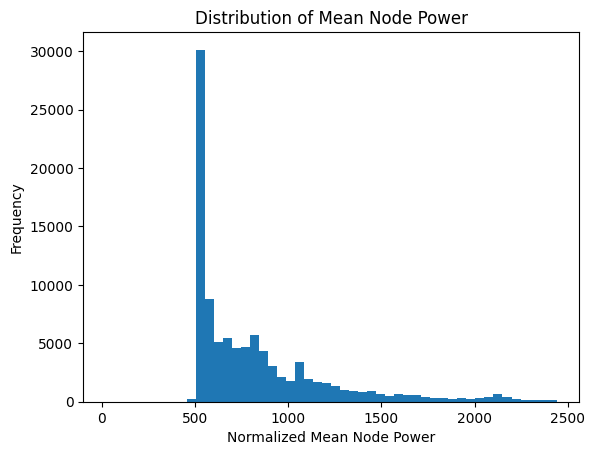

In [83]:
import matplotlib.pyplot as plt

df_filtered['mean_node_power'].plot.hist(bins=50)
plt.title('Distribution of Mean Node Power')
plt.xlabel('Normalized Mean Node Power')
plt.ylabel('Frequency')
plt.show()

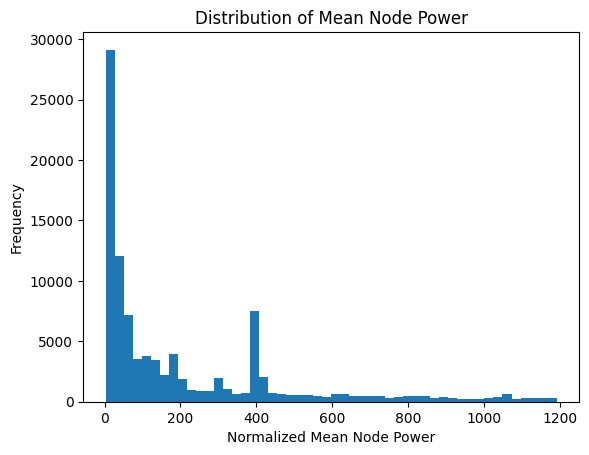

In [84]:
import matplotlib.pyplot as plt

df_filtered['run_time'].plot.hist(bins=50)
plt.title('Distribution of Mean Node Power')
plt.xlabel('Normalized Mean Node Power')
plt.ylabel('Frequency')
plt.show()

In [187]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import numpy as np

# # Assuming your DataFrame is named 'df'

# def investigate_outliers(df, columns):
#     """
#     Investigates potential outliers in specified columns of a DataFrame.

#     Args:
#         df: The pandas DataFrame.
#         columns: A list of column names to investigate.
#     """

#     for col in columns:
#         print(f"\n----- Investigating {col} -----")

#         # Descriptive statistics
#         print(df[col].describe())

#         # Box plot
#         plt.figure(figsize=(8, 4))
#         sns.boxplot(x=df[col])
#         plt.title(f"Box Plot of {col}")
#         plt.show()

#         # Histogram with KDE
#         plt.figure(figsize=(8, 4))
#         sns.histplot(df[col], kde=True, bins=50)
#         plt.title(f"Histogram of {col}")
#         plt.show()

#         # Calculate IQR and identify potential outliers
#         Q1 = df[col].quantile(0.25)
#         Q3 = df[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
#         print(f"\nPotential outliers based on IQR method (>{upper_bound:.2f} or <{lower_bound:.2f}):")
#         print(outliers)

# # Columns to investigate
# cols_to_investigate = ['mean_node_power', 'mean_cpu_power', 'mean_mem_power']

# # Perform the investigation
# investigate_outliers(df, cols_to_investigate)

In [188]:
# import pandas as pd
# import numpy as np

# def handle_outliers_and_skewness(df, columns, capping_percentile=0.995):
#     """
#     Handles outliers by capping at a specified percentile and then applies a log transformation.

#     Args:
#         df: The pandas DataFrame.
#         columns: A list of column names to process.
#         capping_percentile: The percentile to use for capping outliers.
#     """

#     df_processed = df.copy()  # Create a copy to avoid modifying the original DataFrame

#     for col in columns:
#         # Capping
#         upper_limit = df_processed[col].quantile(capping_percentile)
#         df_processed[col] = np.where(df_processed[col] > upper_limit, upper_limit, df_processed[col])

#         # Log transformation
#         df_processed[f"{col}_log"] = np.log1p(df_processed[col])

#     return df_processed

# # Columns to process
# power_cols = ['mean_node_power', 'mean_cpu_power', 'mean_mem_power']

# # Handle outliers and skewness
# df_processed = handle_outliers_and_skewness(df, power_cols, capping_percentile=0.995)

# # Now use 'mean_node_power_log', 'mean_cpu_power_log', and 'mean_mem_power_log' in your GNN training